In [ ]:
!pip install python-Levenshtein

In [ ]:
!pip install kneed

In [38]:
import numpy as np
import pandas as pd
from pandas.io.parsers import StringIO
from io import StringIO

from datetime import date

import Levenshtein as Leven
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import dbscan
from kneed import KneeLocator

from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [39]:
#подгружаем грязные данные
data = pd.read_csv("Data.csv", sep=',')

In [40]:
#удаляем неразделяемые строчки (85)
data['failed'] = data['dept_code'].str.contains(';', regex=True)
data = data[data['failed'] == False]

#удаляем наблюдения до 2001 года (ошибки, например, дата заполнения вместо даты рождения)
data['index'] = range(1, len(data) + 1)
data = data[['index', 'dept_code', 'issue_date', 'issuer_eng' ]]
data['issue_date']= pd.to_datetime(data['issue_date'])
data = data[data['issue_date'].dt.strftime('%Y') >= '2001']

In [41]:
#Готовимся к циклу по регионам: прорабатываем кластеризацию для одного региона
#Датасет с расстояниями
dept_code = data['dept_code'].drop_duplicates()
data_20003 = data[data['dept_code'] == dept_code[0]]
issuers_20003 = data_20003['issuer_eng'].drop_duplicates()
issuers_20003 = issuers_20003.tolist()

X = np.arange(len(issuers_20003)).reshape(-1, 1)

issuers_data_20003 = pd.DataFrame(index=[issuers_20003], columns=[issuers_20003])
for i in range(len(issuers_20003)):
    for j in range(len(issuers_20003)):
        issuer_row = issuers_data_20003.index[i][0]
        issuer_col = issuers_data_20003.columns[j][0]
        issuers_data_20003.iloc[i, j] = Leven.distance(issuer_row, issuer_col)


In [7]:
issuers_data_20003.head()

,OUFMS,MVD PO RESPUBLIKE BASHKORTOSTAN,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR.UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR. UFY,KALININSKIM RUVD G. UFY RESPUBLIKI BASHKORTOSTAN,OTDELOM UFMS ROSSII PO RESPUBLIKI BASHKORTOSTAN V KALININSKOM RAJONE GOR. UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR. UFY +7 927 941 90 90,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAOJNE GOR. UFY,OTDELOM UFMS ROSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR. UFY,OTDEL UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE G. UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALINNINSKOM RAJONE GOR. UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE G. UFY,OTDELENIEM UFMS ROSSII PO RB V KALININSKIM RAJONE GOR. UFY,OTDELOM UFMS ROSSII PO RB V KALININSKOM RAJONE G. UFY,OUFMS ROSSII PO RB V KALINISNKOM RAJONE GOR. UFFY,OTDELENIEM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR. UFY,OTDEL UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM R-NE G.UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KIROVKOM RAJONE GOR.UFY,OTDELOM UFMS ROSSII PO RESPUBLIKEN BASHKORTOSTAN V KALININSKOM RAJONE GOR.UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN GOR. UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALINISNKOM RAJONE GOR. UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORSTOSTAN V KALININSKOM RAJONE GOR. UFY,OTDELOM UFMS PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR.UFA,OTDEL UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR.UFY,OTDELOM UFMS ROSSII PO RB V KALININSKOM RAJONE GOR. UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALINISKOM RAJONE GOR.UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BAKSHORTOSTAN V KALININSKOM RAJONE GOR. UFY,OUFMS ROSSII PO RB V KALINISNKOM RAJONE GOR.UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININGRADSKOM RAJONE GOR. UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALINISKOM RAJONE GOR. UFY,OTDELOM UFMS ROSSII PO RESP BASHKORTOSTAN V KALININSKOM RAJONE GOR UFY,OTDELENIEM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GOR.UFY,OTDELOM UFMS ROSIII PO RESPUBLIKE BASHKORTOSTAN A KALININSKOM RAJONE GOR. UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN KALININSKOM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTSOTAN V KALINISNKOM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKI BASHKORTOSTAN V KALININSKOM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM R-NE GORODA UFY,...,OTDELOM UFMS ROSSII PO RB V KALININSKOM R-NE UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTSOTAN V KALININSKOM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALINISKOM RAJONE GORODA UFY,OTDELOM UFMS PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKIM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALINENKOM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO REPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GORODE UFA,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOJM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALINNINSKOM RAJONE GORODA UFY,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GORODE UFY,OTDELOM UFMS ROSSII PO RESP BASHKORTOSTAN V KALININSKOM R-NE GOR UFY,OTDELOM UFMS ROSSII OTDELOM LIKE BASHKORTOSTANUBLIKE BASHKORTI PO RESPUBM RAJONE GORODA UFY V KALININSKOM RAJN O,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE,OTDELENIEM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTAN V KALININSKOM RAJONE GORODA UFY

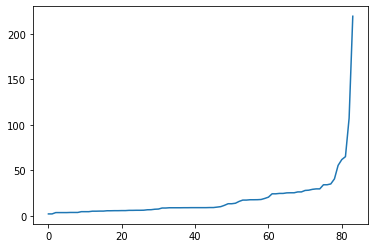

In [42]:
#Подбираем оптимальный eps для кластеризации DBSCAN графически
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(issuers_data_20003)
distances, indices = nbrs.kneighbors(issuers_data_20003)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [43]:
#Подбираем оптимальный eps для кластеризации DBSCAN аналитически
kn = KneeLocator(np.arange(len(distances)), distances, curve='convex', direction='increasing')
print(kn.knee)

77


In [44]:
#Кластеризуем и соединяем с issuer_eng
lev_20003 = dbscan(issuers_data_20003, eps=kn.knee, min_samples=1, n_jobs=-1)
df_20003 = pd.DataFrame(list(zip(issuers_20003, lev_20003[1])), columns =['issuer_eng', 'cluster']) 

In [57]:
# Объединяем всё для одного региона в цикл
clusters = pd.DataFrame(columns =['issuer_eng', 'cluster', 'dept_code'])
dept_code = data['dept_code'].drop_duplicates()
dept_code.index = np.arange(0, len(dept_code))


In [ ]:
#Цикл для кластеризации данных по dept_code
for dept in range(len(dept_code)):
    print(dept)
    data_dept = data[data['dept_code'] == dept_code[dept]]
    issuers_dept = data_dept['issuer_eng'].drop_duplicates()
    issuers_dept = issuers_dept.tolist()
    X = np.arange(len(issuers_dept)).reshape(-1, 1)

    issuers_data_dept = pd.DataFrame(index=[issuers_dept], columns=[issuers_dept])

#Датасет с расстояниями для каждого dept_code в отдельности
    for i in range(len(issuers_dept)):
        for j in range(len(issuers_dept)):
            issuer_row = issuers_data_dept.index[i][0]
            issuer_col = issuers_data_dept.columns[j][0]
            issuers_data_dept.iloc[i, j] = Leven.distance(issuer_row, issuer_col)

#Подбираем оптимальный eps для кластеризации DBSCAN аналитически
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(issuers_data_dept)
    distances, indices = nbrs.kneighbors(issuers_data_dept)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    kn = KneeLocator(np.arange(len(distances)), distances, curve='convex', direction='increasing')

#Кластеризуем и соединяем с issuer_eng
    lev_dept = dbscan(issuers_data_dept, eps=kn.knee, min_samples=1, n_jobs=-1)
    df_dept_clusters = pd.DataFrame(list(zip(issuers_dept, lev_dept[1])), columns =['issuer_eng', 'cluster'])
    df_dept_clusters['dept_code'] = dept_code[dept]
#Оформляем всё в один датасет
    clusters = pd.concat([clusters,df_dept_clusters])

In [59]:
clusters.to_csv('clusters_1.csv')
files.download('clusters_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
#Присоединяем кластеры к изначальным данным
new_data = pd.merge(data, clusters)
new_data.head()

,index,dept_code,issue_date,issuer_eng,cluster
0,1,20003,2001-11-05,OUFMS,0
1,2,20003,2002-03-22,MVD PO RESPUBLIKE BASHKORTOSTAN,1
2,3,20003,2002-05-18,MVD PO RESPUBLIKE BASHKORTOSTAN,1
3,742,20003,2010-12-29,MVD PO RESPUBLIKE BASHKORTOSTAN,1
4,1912,20003,2018-01-11,MVD PO RESPUBLIKE BASHKORTOSTAN,1


In [73]:
#В каждом кластере выделяем наиболее часто встречающееся значение - ядро
grouped = new_data.groupby(['dept_code', 'cluster', 'issuer_eng'], sort=False).count()[['issue_date']]
grouped_max = grouped.groupby(['dept_code', 'cluster']).max()[['issue_date']]
grouped.reset_index(inplace=True)
grouped_max.reset_index(inplace=True)
print(grouped_max)

    dept_code  cluster  issue_date
0       20003        0           1
1       20003        1         179
2       20003        2        1143
3       20003        3           1
4       20003        4           1
..        ...      ...         ...
208    730028        2           1
209    860003        0         945
210    860003        1           1
211    860004        0         556
212    860004        1           1

[213 rows x 3 columns]


In [76]:
#Определяем 'issue_eng' ядер
grouped_max_names = pd.merge(grouped_max, grouped, how = "inner")
grouped_max_names.head()

,dept_code,cluster,issue_date,issuer_eng
0,20003,0,1,OUFMS
1,20003,0,1,MVD PO RB
2,20003,1,179,MVD PO RESPUBLIKE BASHKORTOSTAN
3,20003,2,1143,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...
4,20003,3,1,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...


In [77]:
#Форматируем датасет перед объединением
grouped_max_names['new'] = grouped_max_names['issuer_eng']
grouped_max_names['num'] = grouped_max_names['issue_date']
grouped_max_names = grouped_max_names.drop(columns=['issuer_eng', 'issue_date'])
grouped_max_names.head()

,dept_code,cluster,new,num
0,20003,0,OUFMS,1
1,20003,0,MVD PO RB,1
2,20003,1,MVD PO RESPUBLIKE BASHKORTOSTAN,179
3,20003,2,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...,1143
4,20003,3,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...,1


In [ ]:
#Финальный датасет с именем ядра (для замены) для каждого наблюдения
new_data['cluster'] = new_data['cluster'].astype('int64')
new_data_grouped = pd.merge(grouped_max_names, new_data, how = "inner")

In [85]:
new_data_grouped.to_csv('cleaned_data.csv')
files.download('cleaned_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>